In [ ]:
# Import required libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_columns", None)
plt.style.use('fivethirtyeight')


In [ ]:
# Load the API keys from the login credential file
log_cred = pd.read_csv("login_credentials.csv")
consumer_key = log_cred.iloc[0, 1]
consumer_secret = log_cred.iloc[1, 1]
access_token = log_cred.iloc[2, 1]
access_token_secret = log_cred.iloc[3, 1]


In [ ]:
# Create the authentication object and the API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [48]:
def get_tweets_by_search_term(search_term, num_tweets):
    data = []
    counter = 0
    query_term = f"{search_term} -filter:retweets"
    for tweet in tweepy.Cursor(
        api.search_tweets,
        q=query_term,
        count=num_tweets,
        lang="en",
        tweet_mode="extended",
    ).items():
        tweet_details = {}
        tweet_details["UserId"] = tweet.user.name
        tweet_details["TweetId"] = tweet.id
        tweet_details["tweet"] = tweet.full_text
        tweet_details["location"] = tweet.user.location
        tweet_details["created"] = tweet.created_at.strftime("%d-%b-%Y")
        data.append(tweet_details)
        counter += 1
        if counter == num_tweets:
            break
        else:
            pass
    data_df = pd.DataFrame(data)
    return data_df

In [49]:
search_term =  input("Enter the search term or hashtag here: ") # Use AND or OR to search for multiple terms
no_of_tweets = int(input("Enter the number of tweets to be searched: "))
data_df = get_tweets_by_search_term(search_term, no_of_tweets)
data_df.head()

,UserId,TweetId,tweet,location,created
0,🄼🄰🄶🄰🄽🄶🄰 🄼🅆🄰🄺🅄🄻🄾🄼🄱🄰,1526720457478750214,@kilundeezy The same Kenyans are mad at Sauti sol for claiming their royalties from Azimio.,,18-May-2022
1,eduayawoya,1526719718471639040,Where are the most influential Kenyan politicians\nAZIMIO AMA KENYA KWANZA?,"Kilifi, Kenya",18-May-2022
2,Chelulei,1526718285202477058,@ledamalekina @skmusyoka Never Azimio people are playing tricks with the supper man Kalonzo musy...,,18-May-2022
3,Ephraim Atunga,1526716712418258944,"@UDAPartyKe And they will tell you they were hired, a message to the azimio team Ruto did not on...",Kenya,18-May-2022
4,Karis,1526715191257358338,@KTNNewsKE Madam @mamangilu Kalonzo will Run back to Azimio..but he'll have lost the Credibility...,NBI,18-May-2022


In [50]:
# Primary exploratory analysis
print('Dataset shape:', data_df.shape)
print('Dataset columns:', data_df.columns)
data_df.info()

Dataset shape: (1000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserId    1000 non-null   object
 1   TweetId   1000 non-null   int64 
 2   tweet     1000 non-null   object
 3   location  1000 non-null   object
 4   created   1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [51]:
# Extract the tweets and store them in a dataframe
# Drop all columns except for Tweet and create a list of all words
tweet_df = data_df.drop(['UserId', 'TweetId', 'location', 'created'], axis=1)
tweet_df.head()

,tweet
0,@kilundeezy The same Kenyans are mad at Sauti sol for claiming their royalties from Azimio.
1,Where are the most influential Kenyan politicians\nAZIMIO AMA KENYA KWANZA?
2,@ledamalekina @skmusyoka Never Azimio people are playing tricks with the supper man Kalonzo musy...
3,"@UDAPartyKe And they will tell you they were hired, a message to the azimio team Ruto did not on..."
4,@KTNNewsKE Madam @mamangilu Kalonzo will Run back to Azimio..but he'll have lost the Credibility...


In [52]:
# Clean Data - Remove special characters, links, and other elements
# Create a function to clean the data
def clean_tweet(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove the # in #hashtag
    text = re.sub(r'RT[\s]+', '', text) # Remove RT (retweet)
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlinks

    return text

In [54]:
# Apply the function to the dataframe
tweet_df['tweet'] = tweet_df['tweet'].apply(clean_tweet)
# Show cleaned tweets
tweet_df.head(10)

,tweet
0,The same Kenyans are mad at Sauti sol for claiming their royalties from Azimio.
1,Where are the most influential Kenyan politicians\nAZIMIO AMA KENYA KWANZA?
2,Never Azimio people are playing tricks with the supper man Kalonzo musyoka he will never come ...
3,"And they will tell you they were hired, a message to the azimio team Ruto did not only hire our..."
4,Madam Kalonzo will Run back to Azimio..but he'll have lost the Credibility.Lead like you've al...
5,"In the unlikely event Azimio wins: Karua greases her bloated ego,develops tantrums and resigns. ..."
6,"Kalonzo doing the most🤣🤣🤣, his people should with emergency find another leader asap or else th..."
7,"something completely new to the table, a female DP. This will significantly increase the tally..."
8,"He is Not going to campaign or even be on the ballot!Uhuru will call him,he gets mpesa text,wi..."
9,That is after AZIMIO realized that the plan to merge with him in the RUNOFF wont work since RUT...


In [56]:
# Create subjectivity and polarity then save to dataframe in new columns
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

tweet_df['Subjectivity'] = tweet_df['tweet'].apply(get_subjectivity)
tweet_df['Polarity'] = tweet_df['tweet'].apply(get_polarity)
tweet_df.head(10)

,tweet,Subjectivity,Polarity
0,The same Kenyans are mad at Sauti sol for claiming their royalties from Azimio.,0.562500,-0.312500
1,Where are the most influential Kenyan politicians\nAZIMIO AMA KENYA KWANZA?,0.500000,0.500000
2,Never Azimio people are playing tricks with the supper man Kalonzo musyoka he will never come ...,0.000000,0.000000
3,"And they will tell you they were hired, a message to the azimio team Ruto did not only hire our...",1.000000,0.000000
4,Madam Kalonzo will Run back to Azimio..but he'll have lost the Credibility.Lead like you've al...,0.000000,0.000000
5,"In the unlikely event Azimio wins: Karua greases her bloated ego,develops tantrums and resigns. ...",0.500000,-0.133333
6,"Kalonzo doing the most🤣🤣🤣, his people should with emergency find another leader asap or else th...",0.833333,0.133333
7,"something completely new to the table, a female DP. This will significantly increase the tally...",0.499053,0.127841
8,"He is Not going to campaign or even be on the ballot!Uhuru will call him,he gets mpesa text,wi...",0.000000,0.000000
9,That is after AZIMIO realized that the plan to merge with him in the RUNOFF wont work since RUT...,0.400000,0.300000


(-0.5, 399.5, 199.5, -0.5)

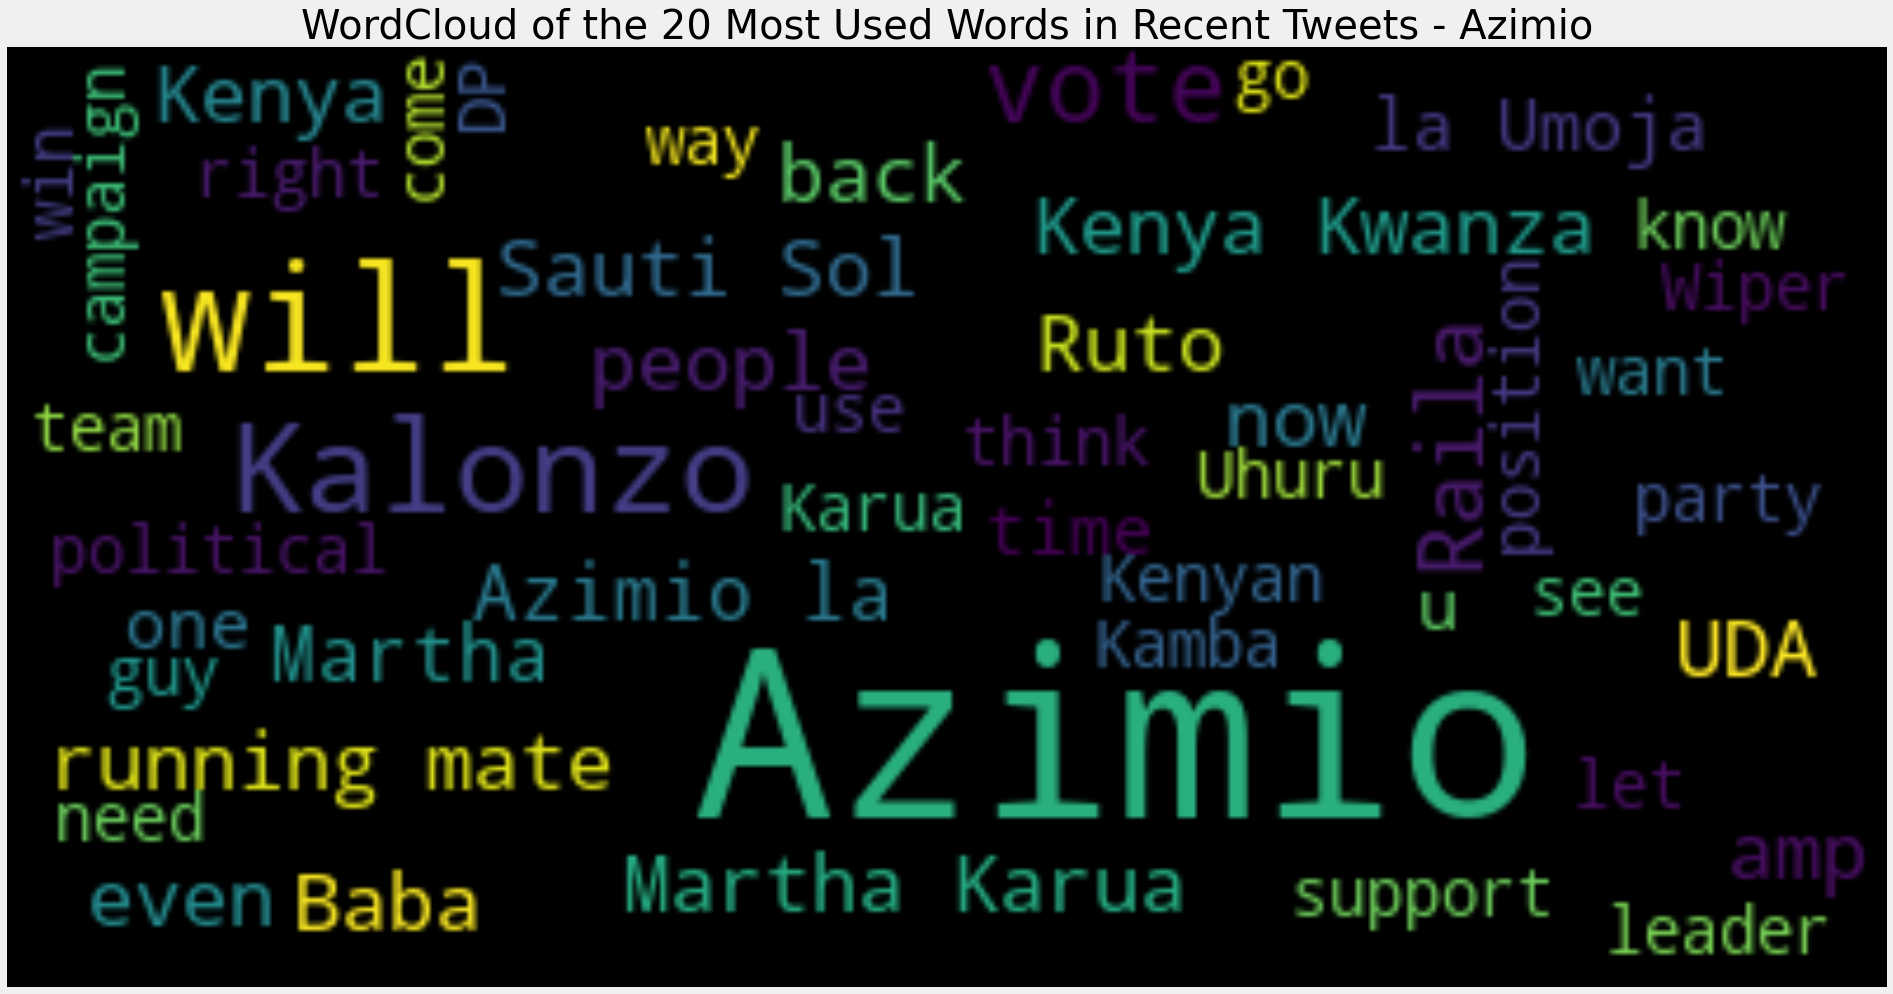

In [57]:
# Wordcloud of the top 100 most used words
all_words = ' '.join([text for text in tweet_df['tweet']])

fig, ax = plt.subplots(figsize=(30, 40))
word_cloud = WordCloud(max_font_size=50, max_words=50, random_state=21).generate(all_words)

ax.imshow(word_cloud, interpolation='bilinear')
ax.set_title(f'WordCloud of the 20 Most Used Words in Recent Tweets - {search_term}', fontsize=40)
ax.axis("off")

In [58]:
# Compute negative, neutral, positive analysis of the tweets
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score== 0:
        return 'Neutral'
    else:
        return 'Positive'

tweet_df['Analysis'] = tweet_df['Polarity'].apply(get_analysis)

Text(0.5, 1.0, 'Analysis of Tweets by search terms - Azimio')

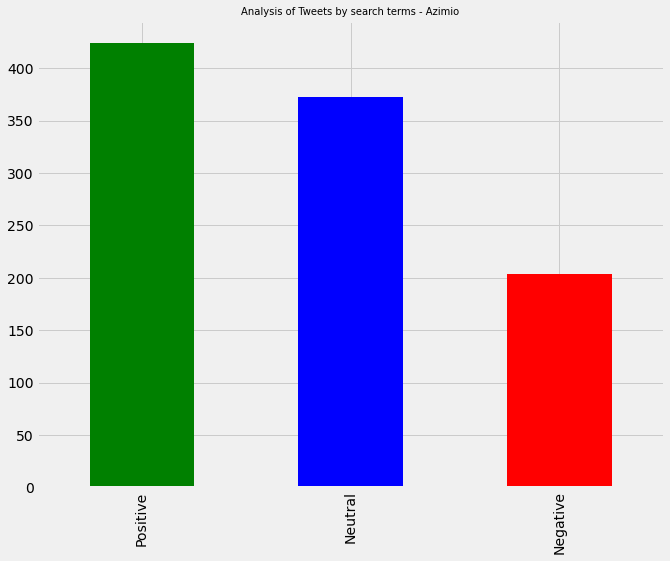

In [59]:
# Plotting the polarity of the tweets
ax = tweet_df['Analysis'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'], figsize=(10, 8))
ax.set_title(f'Analysis of Tweets by search terms - {search_term}', fontsize=20)

In [60]:
def get_subjectivity_analysis(score):
    if score < 0.5:
        return 'Objective'
    else:
        return 'Subjective'

tweet_df['Subjectivity_Analysis'] = tweet_df['Subjectivity'].apply(get_subjectivity_analysis)
tweet_df.head(10)

,tweet,Subjectivity,Polarity,Analysis,Subjectivity_Analysis
0,The same Kenyans are mad at Sauti sol for claiming their royalties from Azimio.,0.562500,-0.312500,Negative,Subjective
1,Where are the most influential Kenyan politicians\nAZIMIO AMA KENYA KWANZA?,0.500000,0.500000,Positive,Subjective
2,Never Azimio people are playing tricks with the supper man Kalonzo musyoka he will never come ...,0.000000,0.000000,Neutral,Objective
3,"And they will tell you they were hired, a message to the azimio team Ruto did not only hire our...",1.000000,0.000000,Neutral,Subjective
4,Madam Kalonzo will Run back to Azimio..but he'll have lost the Credibility.Lead like you've al...,0.000000,0.000000,Neutral,Objective
5,"In the unlikely event Azimio wins: Karua greases her bloated ego,develops tantrums and resigns. ...",0.500000,-0.133333,Negative,Subjective
6,"Kalonzo doing the most🤣🤣🤣, his people should with emergency find another leader asap or else th...",0.833333,0.133333,Positive,Subjective
7,"something completely new to the table, a female DP. This will significantly increase the tally...",0.499053,0.127841,Positive,Objective
8,"He is Not going to campaign or even be on the ballot!Uhuru will call him,he gets mpesa text,wi...",0.000000,0.000000,Neutral,Objective
9,That is after AZIMIO realized that the plan to merge with him in the RUNOFF wont work since RUT...,0.400000,0.300000,Positive,Objective


Text(0.5, 1.0, 'Subjectivity Analysis of Tweets - Azimio')

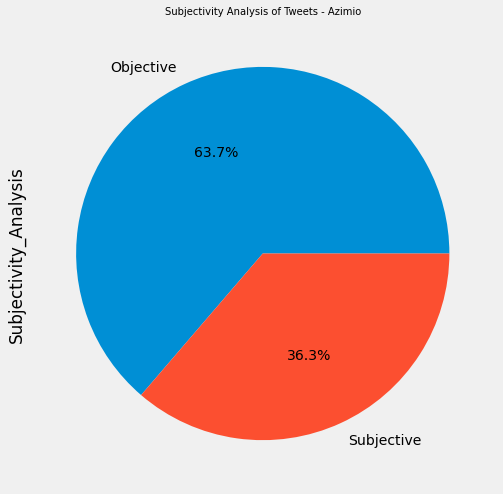

In [61]:
# Plotting the polarity of the tweets
ax = tweet_df['Subjectivity_Analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax.set_title(f'Subjectivity Analysis of Tweets - {search_term}', fontsize=10)

Text(0.5, 1.0, '% of Positive, Negative and Neutrral Tweets - Azimio')

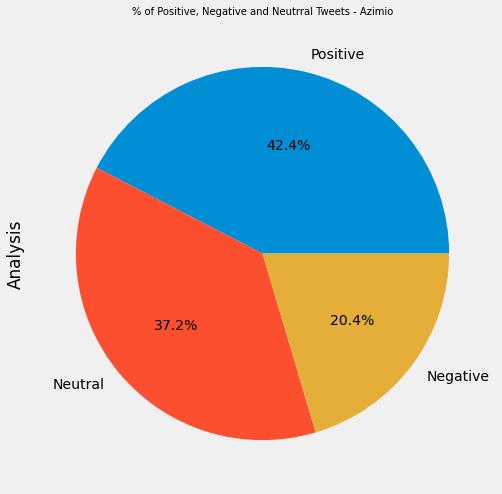

In [62]:
# Pie chart of the polarity of the tweets
ax = tweet_df['Analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax.set_title(f'% of Positive, Negative and Neutrral Tweets - {search_term}', fontsize=10)


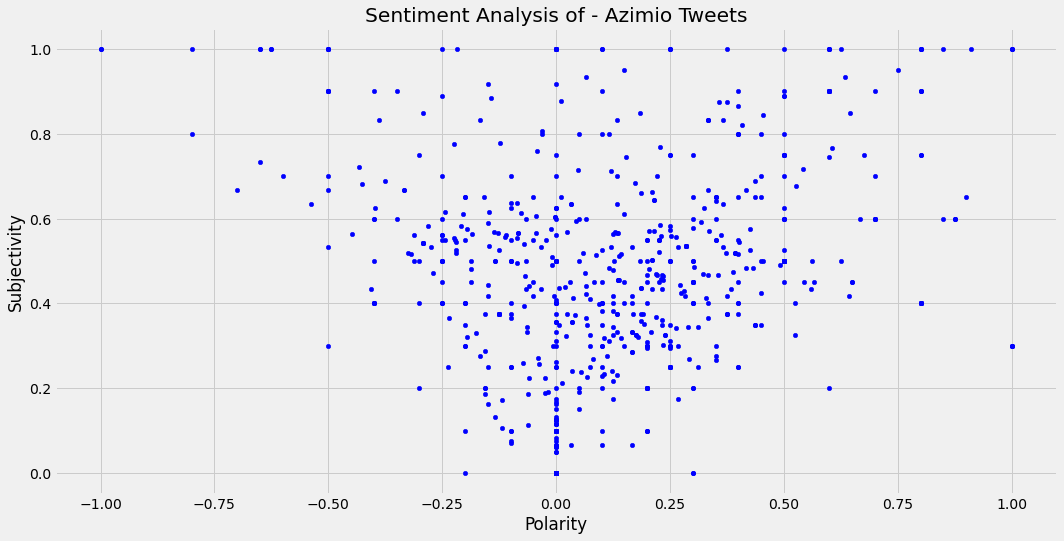

In [63]:
# Plot polarity and subjectivity of the tweets
ax = tweet_df.plot(kind='scatter', x='Polarity', y='Subjectivity', color='blue', figsize=(16,8))
ax.title.set_text(f'Sentiment Analysis of - {search_term} Tweets')